In [1]:
# import necessary packages
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open("camera_cal/wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [3]:
# Read in an image
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Undistortion

Text(0.5,1,'Undistorted Image')

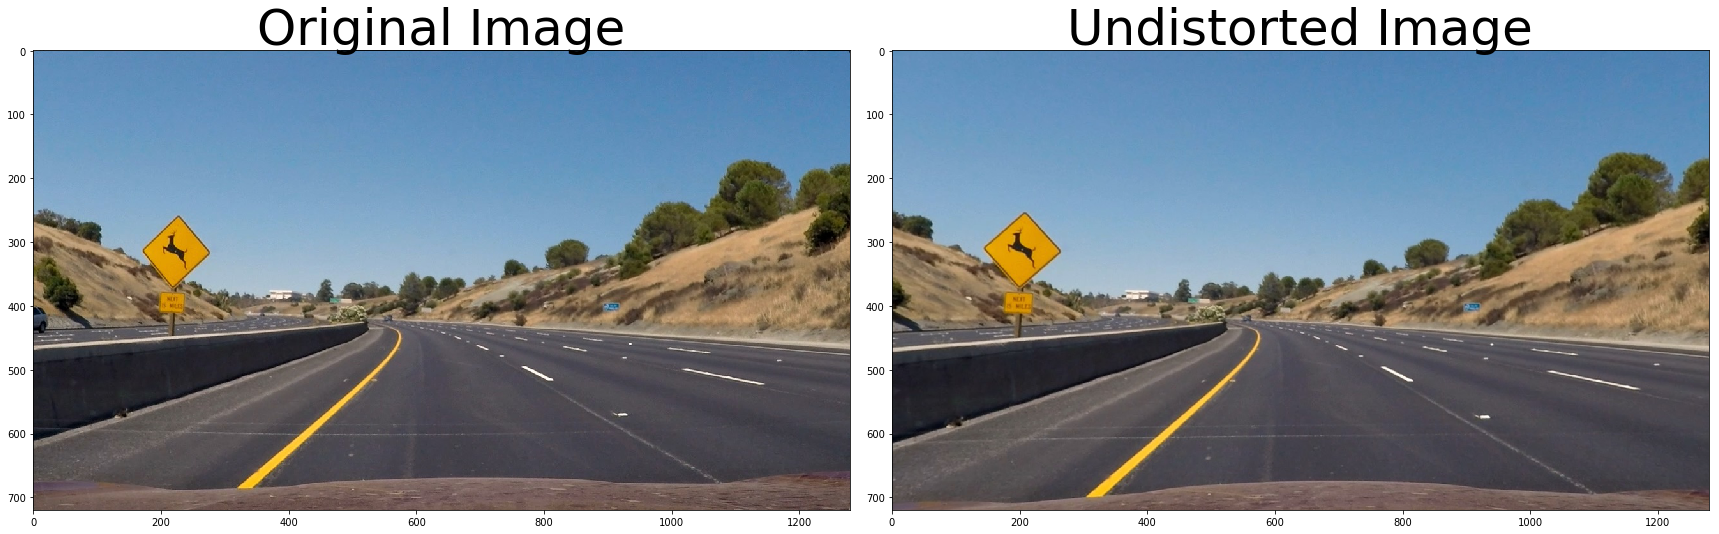

In [11]:
# Use the OpenCV undistort() function to remove distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test2_undist.jpg', undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)

## Perspective Transformation

Text(0.5,1,'Warped Image')

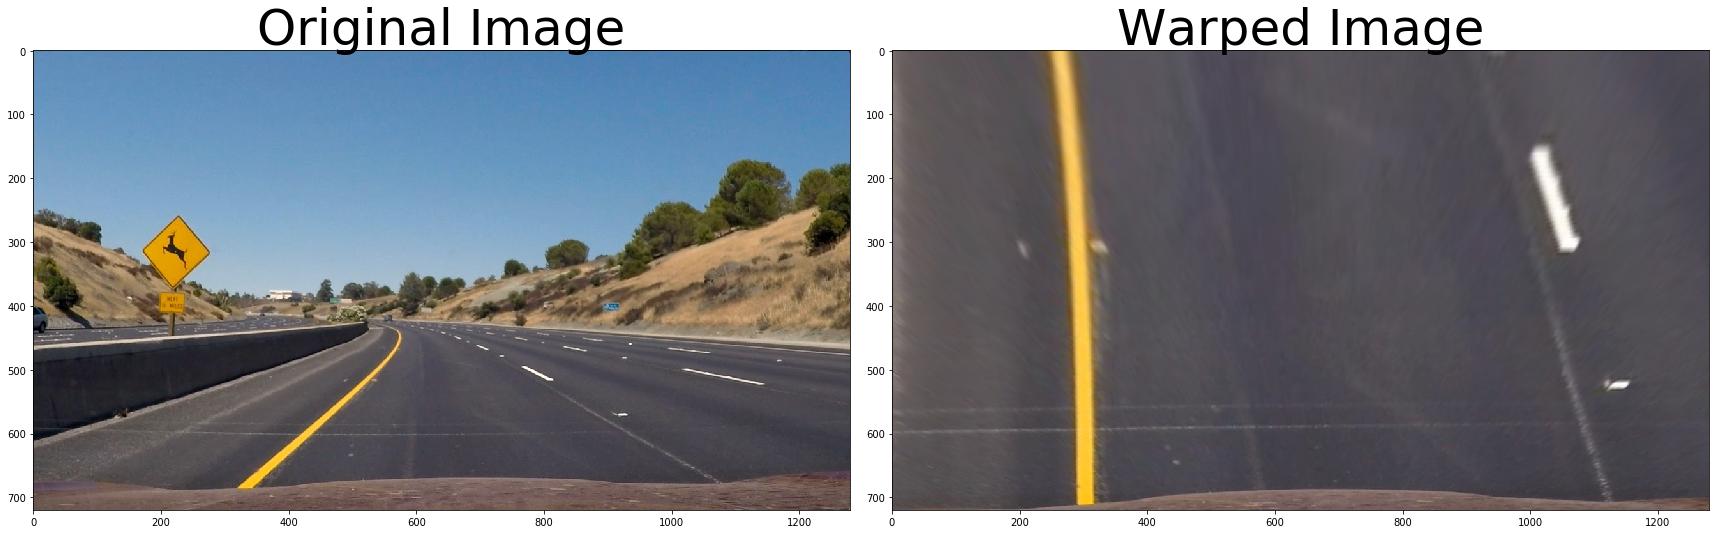

In [5]:
offset = 10 # offset for src points
# Grab the image shape
img_size = (img.shape[1], img.shape[0])
# Set the source and destination points
src = np.float32([[(0, img_size[1]-offset), (490, 480), (820, 480), (img_size[0],img_size[1]-offset)]])
dst = np.float32([[(0,img_size[1]), (0, 0), (img_size[0], 0), (img_size[0],img_size[1])]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# calculate inverse perspective transform matrix
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, img_size)
cv2.imwrite('output_images/test2_warped.jpg', warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)

## Thresholding 

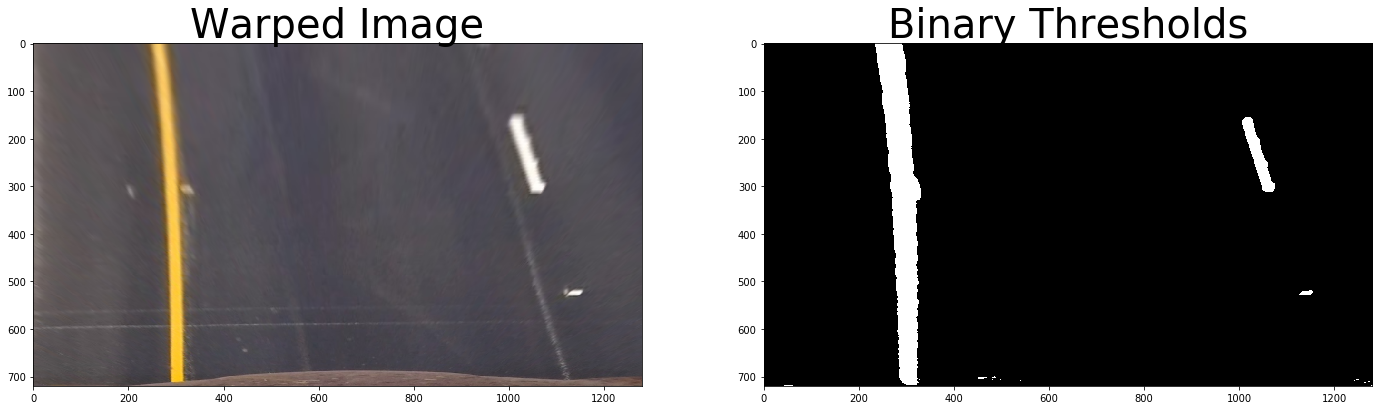

In [14]:
# convert to LAB color space and perform thresholding using B channel
lab = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)
b_channel = lab[:,:,2]
b_thresh_min = 140
b_thresh_max = 200
b_binary = np.zeros_like(b_channel)
b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

# convert to LUV color space and perform thresholding using L channel
luv = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)
l_channel = luv[:,:,0]
l_thresh_min = 195
l_thresh_max = 255
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
# Combine the two binary thresholds
combined_binary = np.zeros_like(b_binary)
combined_binary[(b_binary == 1) | (l_binary == 1)] = 1

# save image
cv2.imwrite('output_images/test2_thresh.jpg', combined_binary)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.set_title('Warped Image', fontsize=40)
ax1.imshow(warped)
ax2.set_title('Binary Thresholds', fontsize=40)
ax2.imshow(combined_binary, cmap='gray')

## Identify lane line pixels and fit via polynomials

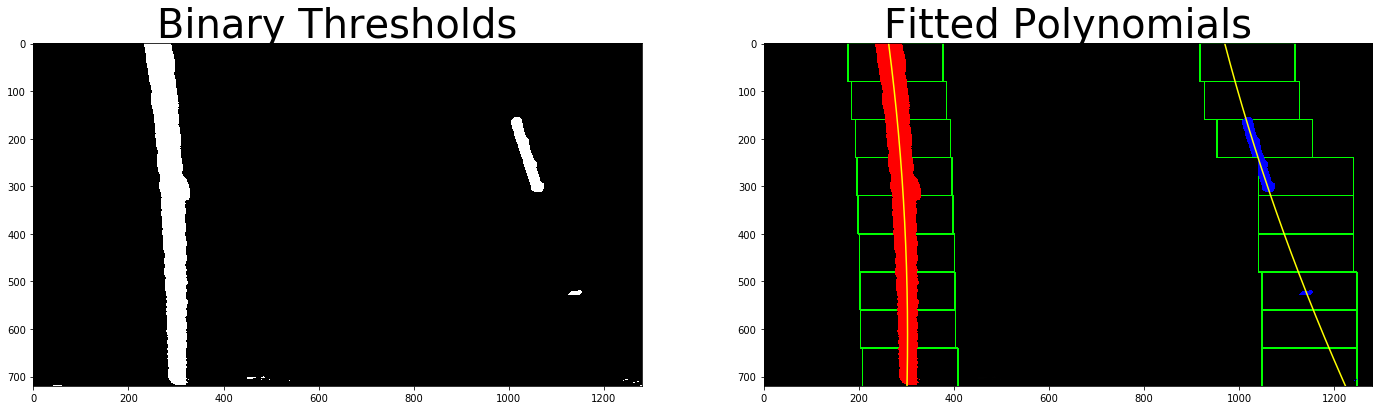

In [18]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit


out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(combined_binary)

# save image
cv2.imwrite('output_images/test2_fitted.jpg', out_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.set_title('Binary Thresholds', fontsize=40)
ax1.imshow(combined_binary, cmap='gray')
ax2.set_title('Fitted Polynomials', fontsize=40)
# Plots the left and right polynomials on the lane lines
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.imshow(out_img)

# Calculate Radius of Curvature and Offset

In [19]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Define y-value where we want radius of curvature
# We'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

# Calculation of R_curve (radius of curvature)
left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

midpoint = np.int(undist.shape[1]/2)
middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
offset = (midpoint - middle_of_lane) * xm_per_pix

print('Radius of Curvature of Left Lane is', left_curverad, 'm')
print('Radius of Curvature of Right Lane is', right_curverad, 'm')
print('Position of the vehicle with respect to center (offset) is', offset, 'm')

Radius of Curvature of Left Lane is 4887.37095403 m
Radius of Curvature of Right Lane is 4377.37300474 m
Position of the vehicle with respect to center (offset) is -0.644657636674 m


## Final image with identified the lane boundaries

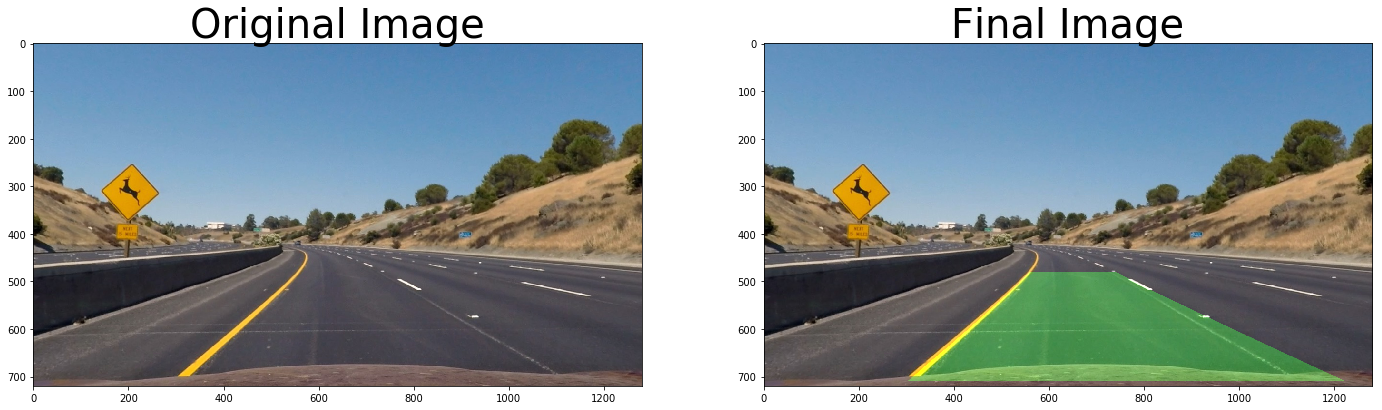

In [21]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

# save image
cv2.imwrite('output_images/test2_final.jpg', result)

# Plotting original and final images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.set_title('Original Image', fontsize=40)
ax1.imshow(undist)
ax2.set_title('Final Image', fontsize=40)
ax2.imshow(result, cmap='gray')